In [ ]:
#### Script written by Yash Gupta ####

In [92]:
# Import libraries!
import numpy as np
import pandas as pd
import scipy.stats as ss
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import copy

In [224]:
'''
Below class creates an environment/map with each node as a charging station or just a freeway/road.
Details for later additions to the class to be explained soon!!

'''

class EVRoutePlanning_MCTS:
    def __init__(
        self,
        X: int = 10,
        Y: int = 10,
        grid_length: int = 10,
        num_chargers: int = 10
    ):
        self.X = X # size of map/grid in X direction
        self.Y = Y # size of map/grid in Y direction
        self.grid_length = grid_length # length/size of grid(square) in miles
        self.map_shape = (self.X, self.Y)
        self.num_chargers = num_chargers # total number of chargers on the map
        self.map, self.charging_stations = self._initialize_map_with_charging_stations()
        self.charging_wait_times = {} # dictionary for wait times (in minutes) for every charger at each hour of the day
        self.origin = 0 # index of origin on the map/grid
        self.destination = 0 # index of destination on the map/grid
        self.start_time = datetime.fromisoformat("2023-03-01") # start time of the journey
        self.start_soc = 0.85 # start soc of the journey
        self.desired_soc = 0.5 # desired soc at the end of the journey
        self.vehicle_range = 400 # maximum range of the car in miles
        self.minimum_journey_time = 0 # minimum time(in minutes) required to reach the destination
        self.max_soc = 0.95 # max soc upto which charging is recommended
        self.min_soc = 0.15 # min soc going below which isn't recommended
        self.charging_rate = 5 # charging rate = 5 miles/minute
        self.chargers_on_route = [] # to store the list of feasible chargers
        self.reachable_chargers = {} # to store the list of reachable chargers from the current position/index
        self.history = {} # dictionary to store the history of the route taken during MCTS
        self.position_reward = np.zeros(shape = self.map_shape) # rewards based on positions on the map/grid
        self.value_function = np.zeros(shape = self.map_shape) # value function for each positions on the map/grid

    
    def _initialize_map_with_charging_stations(self):
        map = np.zeros(shape = self.map_shape, dtype = int)
        charging_stations = np.random.choice(np.arange(self.X * self.Y - 1, dtype = int), 
                                             size = self.num_chargers, 
                                             replace = False)
        for index in charging_stations:
            i, j = np.unravel_index(index, shape = self.map_shape)
            map[i][j] = 1
        
        return map, charging_stations
    
    
    def generate_wait_time_distribution_per_charger(self, prob_peak_hour, list_sd_hours, list_peak_wait_time, prob_peak_wait_time):
        '''prob_peak_hour is a list of size 24 with probability values such that peak time(hour) 
        of the day for a charger occurs at hour "i" i.e., P(peak_hour == i) = prob_peak_hour[i]
        Note - sum(prob_peak_hour) should be equal to 1, ofcourse!! 
        
        list_sd_hours is a list of choices given for choosing the standard deviation of the 
        wait time distributon at each charger. An example of this list could be [2, 3, 4] or 
        [3, 4, 5] or even [4] which means a fixed standard deviation of 4 hours for each charger.

        list_peak_wait_time is a list of choices given for choosing the expected wait time at 
        peak hour of the day for each charger. An example of this list could be [20, 30, 40, 50]
        or [25, 30, 35, 40, 50, 60]. We can also give as input, in prob_peak_wait_time, the 
        probability for each wait time choices in the list to make it more realistic.
        '''

        list_hours = np.arange(24, dtype = int)
        for charger_index in self.charging_stations:
            peak_hour = np.random.choice(a = list_hours, 
                                         size = 1, 
                                         p = prob_peak_hour)
            sd_hour = np.random.choice(a = list_sd_hours,
                                       size = 1)
            peak_wait_time = np.random.choice(a = list_peak_wait_time,
                                              size = 1,
                                              p = prob_peak_wait_time)

            # create a random variable for wait time distribution
            # Please refer to scipy.stats.truncnorm for details of the following distribution
            a = -12 / sd_hour
            b = 11 / sd_hour
            rv = ss.truncnorm(a, b, loc = peak_hour, scale = sd_hour)
            peak_pdf = rv.pdf(peak_hour)
            for i in range(-12, 12):
                hour = (i + peak_hour + 24) % 24
                wait_time = int(rv.pdf(i + peak_hour) / peak_pdf * peak_wait_time)
                key = str(charger_index) + ',' + str(hour[0])
                self.charging_wait_times[key] = wait_time
        return
    
    
    def _distance_between_two_index(self, P, Q):
        x1, y1 = np.unravel_index(P, shape = self.map_shape)
        x2, y2 = np.unravel_index(Q, shape = self.map_shape)
        distance = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
        distance = distance * self.grid_length # conversion to miles
        return distance
    
    
    def _calculate_minimum_journey_time(self, index_cur, soc_cur, index_next, soc_next):
        '''This function calculates the minimum journey time required to reach 
        the next position from the current position by computing total distance to be 
        travelled, current soc, desired soc, vehicle range, average vehicle speed 
        and charging speed.'''

        total_journey_distance = self._distance_between_two_index(index_cur, index_next) # in miles
        dest_soc = soc_cur - total_journey_distance / self.vehicle_range # soc at destination if not charged
        required_charging_time = int((soc_next - dest_soc) * self.vehicle_range / self.charging_rate) # answer in minutes
        minimum_journey_time = total_journey_distance + required_charging_time # in minutes - assuming average vehicle speed of 1 miles/min

        return minimum_journey_time
    
    
    def create_journey(self, origin, destination, start_time, start_soc = 0.85, desired_soc = 0.5, 
                       vehicle_range = 220, region_of_influence = 0.1):
        '''This function allows us to create a journey for an origin-destination pair. 
        It simply means that we now have a game/problem for our given environment/map 
        for which we need to do route planning/finding the best optimal policy.
        
        minimum_journey_time is estimated for the origin-destination pair'''

        self.origin = origin
        self.destination = destination
        self.start_time = start_time
        self.start_soc = start_soc
        self.desired_soc = desired_soc
        self.vehicle_range = vehicle_range
        self.minimum_journey_time = self._calculate_minimum_journey_time(origin, start_soc, destination, desired_soc)

        # Find the list of chargers on route of our current journey using origin-destination pair
        self.chargers_on_route = self._find_chargers_on_route(region_of_influence = region_of_influence)
        return
    
    
    def _find_chargers_on_route(self, region_of_influence = 0.1):
        '''This function identifies the list of feasible chargers that lie within the 
        region of influence of our journey.'''
        distance_org_dest = self._distance_between_two_index(self.origin, self.destination) # in miles
        if(region_of_influence <= 1):
            boundary_distance = distance_org_dest * (1 + 2 * region_of_influence) # if region_of_influence is a function of distance_org_dest
        else:
            boundary_distance = distance_org_dest + 2 * region_of_influence
        
        # Find the chargers that lie within the boundary distance
        chargers_on_route = []
        for index in self.charging_stations:
            distance_metric = self._distance_between_two_index(index, self.origin) + self._distance_between_two_index(index, self.destination)
            if(distance_metric <= boundary_distance):
                chargers_on_route.append(index)
        
        return chargers_on_route
    
    
    def _reachable_chargers(self, current_state):
        index_cur, time_cur, soc_cur = current_state # extracting the variables associated with the current state
        if(soc_cur <= self.min_soc):
            print("Trip not Possible for the given vehicle!")
        max_distance = (soc_cur - self.min_soc) * self.vehicle_range # answer in miles

        list_reachable_charger = [] # list to store the reachable chargers
        # list_distance_to_destination = [] # distance to destination from the charger
        for index in self.chargers_on_route:
            distance_cur = self._distance_between_two_index(index, index_cur) # in miles
            if(distance_cur <= max_distance):
                list_reachable_charger.append(index)
                # distance_dest = self._distance_between_two_index(index, self.destination) # in miles
                # list_distance_to_destination.append(distance_dest)
        self.reachable_chargers[str(index_cur)] = list_reachable_charger
        
        return
    
    
    def _transition_model(self, current_state, index_next):
        '''current_state is in the form of (index_cur, time_cur, soc_cur) and it returns 
        the final state in the same format after computing the time_next and soc_next for 
        the given next position'''

        index_cur, time_cur, soc_cur = current_state # extracting the variables associated with the current state
        distance_cur_next = self._distance_between_two_index(index_cur, index_next) # in miles
        time_next = time_cur + timedelta(minutes = distance_cur_next) # assuming average speed of 1 miles/min
        soc_next = soc_cur - distance_cur_next / self.vehicle_range # soc at next position

        # Just a check - Logically, code should never enter this if condition
        if(soc_next < self.min_soc):
            print("Invalid next position")
            return current_state
        
        # perform charging operations if next index is a charger
        if(index_next != self.destination):
            key = str(index_next) + ',' + str(time_next.hour)
            wait_time = self.charging_wait_times[key]
            time_next = time_next + timedelta(minutes = wait_time) # add waiting time
            charging_time = int((self.max_soc - soc_next) * self.vehicle_range / self.charging_rate) # answer in minutes
            soc_next = self.max_soc # update the soc after charging is done!
            time_next = time_next + timedelta(minutes = charging_time) # add charging time
            buffer_time = np.random.choice([5.,10.]) # assuming 5 or 10 minutes buffer time for charging set up and hitting the road
            time_next = time_next + timedelta(minutes = buffer_time)
        
        # variables for the next state
        next_state = (index_next, time_next, soc_next)

        return next_state
    
    
    def _time_reward(self, next_state):
        # index_cur, time_cur, soc_cur = current_state # extracting the variables associated with the current state
        index_next, time_next, soc_next = next_state # extracting the variables associated with the next state

        # # Just a check - Logically, code should never enter this if condition
        # if(index_next == index_cur):
        #     return -1000 # return a very low reward for no transition
        
        journey_time_till_next = (time_next - self.start_time) / timedelta(minutes = 1)
        minimum_journey_time_remaining = self._calculate_minimum_journey_time(index_next, soc_next, self.destination, self.desired_soc)
        total_minimum_journey_time = journey_time_till_next + minimum_journey_time_remaining
        
        # calculate the time reward
        time_reward = 1 - (total_minimum_journey_time / self.minimum_journey_time)

        return time_reward
    
    
    # ToCheck - Might not need this function at all
    def _distance_reward(self, index_cur, index_next):
        # compute the required distance values
        distance_next_dest = self._distance_between_two_index(index_next, self.destination) # in miles
        distance_cur_dest = self._distance_between_two_index(index_cur, self.destination) # in miles
        distance_org_dest = self._distance_between_two_index(self.origin, self.destination) # in miles

        # To-Check: Test both the choices in getting the results
        # Choice 1
        # distance_reward = 1 - (distance_next_dest / distance_cur_dest) # using current position as reference
        # Choice 2
        distance_reward = 1 - (distance_next_dest / distance_org_dest) # using origin as reference

        return distance_reward
    

    def _choose_next_state(self, current_state, epsilon = 0.5):
        index_cur, time_cur, soc_cur = current_state # extracting the variables associated with the current state
        key = str(index_cur) # key to extract the list of reachable chargers from the current index/state
        if key in self.reachable_chargers:
            list_reachable_charger = self.reachable_chargers[key]
        else:
            self._reachable_chargers(current_state=current_state)
            list_reachable_charger = self.reachable_chargers[key]
        
        num_reachable_charger = len(list_reachable_charger)
        if(num_reachable_charger == 0):
            # Trip not Possible for the given vehicle as there are no reachable chargers
            return False
        elif(num_reachable_charger > 5):
            num_reachable_charger = 5 # choose 5 or 10 states based on the required running time
            # prune to a few random choices for next state to save time
            list_reachable_charger = np.random.choice(list_reachable_charger, size=num_reachable_charger)

        # To-Do: Use one-step lookahead to compute the value function for each action/reachable charger
        list_value_function = np.zeros(num_reachable_charger) # currently it is zero
        list_reward = np.zeros(num_reachable_charger)
        list_next_state = []
        for i in range(num_reachable_charger):
            distance_reward = self._distance_reward(index_cur, list_reachable_charger[i]) # distance reward
            # using transition model get the next state variables
            next_state = self._transition_model(current_state, list_reachable_charger[i])
            list_next_state.append(next_state)
            time_reward = self._time_reward(next_state) # time reward
            list_reward[i] = distance_reward + time_reward # total reward
        
        # Use epsilon-greedy exploration
        if (np.random.rand() < epsilon):
            next_state = list_next_state[np.random.choice(num_reachable_charger)] # choose next state randomly
        else:
            next_state = list_next_state[np.argmax(list_reward)] # choose next state greedily
        
        return next_state
    
    def _can_reach_destination(self, current_state):
        '''Check if the vehicle can reach the destination from the current position with 
        an soc greater than or equal to the desired soc.'''
        index_cur, time_cur, soc_cur = current_state # extracting the variables associated with the current state
        max_distance = (soc_cur - self.desired_soc) * self.vehicle_range # answer in miles
        distance_dest = self._distance_between_two_index(index_cur, self.destination) # in miles
        if(distance_dest <= max_distance):
            return True
        else:
            return False

    def monte_carlo_tree_search(self, num_policy = 10, epsilon = 0.5, alpha = 0.9):
        list_policies = [] # to store the list of policies
        list_total_journey_distance = [] # to store the total distance travelled
        list_total_journey_time = [] # to store the total journey time
        list_total_charging_time = [] # to store total wait time incurred during the journey
        for itr in range(num_policy):
            store_chargers_on_route = copy.deepcopy(self.chargers_on_route)
            current_state = (self.origin, self.start_time, self.start_soc) # initialize the current state
            index_cur, time_cur, soc_cur = current_state
            next_state = current_state
            index_next, time_next, soc_next = next_state
            policy = [self.origin]
            total_journey_distance = 0
            k_max = 100
            k = 0
            while(index_next != self.destination):
                k = k + 1
                current_state = next_state
                index_cur, time_cur, soc_cur = current_state
                if self._can_reach_destination(current_state):
                    next_state = self._transition_model(current_state=current_state, index_next=self.destination)
                else:
                    next_state = self._choose_next_state(current_state=current_state, epsilon=epsilon)
                if(next_state == False):
                    print("Trip not Possible for the given vehicle!")
                    break
                index_next, time_next, soc_next = next_state
                # remove the charging station already visited from the list of chargers on route
                if index_cur in self.chargers_on_route:
                    self.chargers_on_route.remove(index_cur)
                # print(np.unravel_index(index_next, shape = self.map_shape))
                policy.append(index_next) # append the next state index to the policy/route
                total_journey_distance = total_journey_distance + self._distance_between_two_index(index_cur, index_next)
                if(k == k_max):
                    break

            total_journey_time = (time_next - self.start_time) / timedelta(minutes = 1)
            dest_soc = self.start_soc - total_journey_distance / self.vehicle_range # soc at destination if not charged
            total_charging_time = int((soc_next - dest_soc) * self.vehicle_range / self.charging_rate) # answer in minutes
            list_policies.append(policy)
            list_total_journey_distance.append(int(total_journey_distance))
            list_total_journey_time.append(int(total_journey_time))
            list_total_charging_time.append(int(total_charging_time))

            epsilon = alpha * epsilon # epsilon decay using alpha
            self.chargers_on_route = copy.deepcopy(store_chargers_on_route) # revert to the original list
        
        return list_policies, list_total_journey_distance, list_total_journey_time, list_total_charging_time
    

    def policy_evaluation(self, list_policies, list_total_journey_distance, list_total_journey_time, list_total_charging_time):
        num_policies = len(list_policies)
        policy_df = pd.DataFrame()
        policy_df['Policy No.'] = ["Policy " + str(i + 1) for i in range(num_policies)]
        policy_df['Distance'] = list_total_journey_distance # in miles
        policy_df['Journey Time'] = list_total_journey_time # in minutes
        policy_df['Charging Time'] = list_total_charging_time # in minutes
        policy_df['Waiting Time'] = policy_df['Journey Time'] - policy_df['Distance'] - policy_df['Charging Time'] # in minutes

        return policy_df



In [226]:
# Testing the environment
m = EVRoutePlanning_MCTS(X=100, Y=100, grid_length=10, num_chargers=50)

C:\Users\Yash\AppData\Local\Temp\ipykernel_18948\2370057239.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


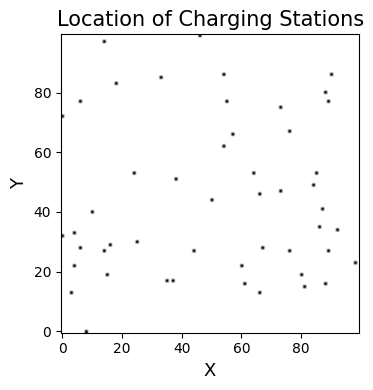

In [227]:
# Plot the map with the location of all charging stations
fig, ax = plt.subplots(figsize=(4, 4))

ax.imshow(m.map, cmap = 'binary')
ax.invert_yaxis()
ax.set_title('Location of Charging Stations', fontsize = 15)
ax.set_xlabel('X', fontsize = 13)
ax.set_ylabel('Y', fontsize = 13)
fig.tight_layout()
fig.show()

In [228]:
# Generate the wait time distribution with hour for each charging station
m.generate_wait_time_distribution_per_charger(prob_peak_hour=[1/24] * 24 , list_sd_hours=[3,4], list_peak_wait_time=[20,25,30], prob_peak_wait_time=[0.3,0.4,0.3])

In [229]:
# Sample an origin-destination pair
o, d = np.random.choice(np.arange(m.X * m.Y), 2)
date = datetime.fromisoformat("2020-03-01-09")

In [242]:
m.create_journey(origin=o, destination=d, start_time=date, start_soc=0.99, desired_soc=0.4, vehicle_range=300, region_of_influence=0.9)

In [ ]:
# Get the list of optimal policy/route using monte carlo tree search
list_policies, list_distance, list_journey_time, list_charging_time = m.monte_carlo_tree_search(2, 0.5, 0.9)

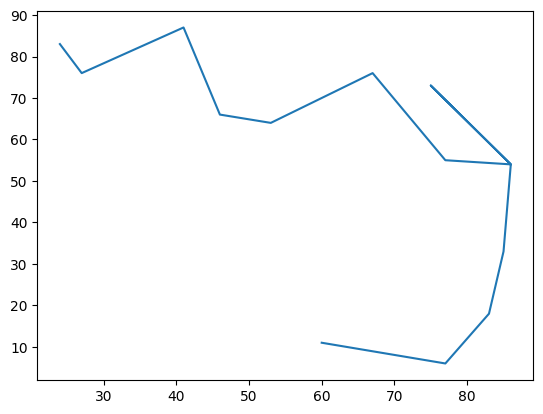

In [255]:
x_temp, y_temp = np.unravel_index(list_policies[1], shape = m.map_shape)
plt.plot(x_temp, y_temp)

In [247]:
# Compare and evaluate all the policies
policy_df = m.policy_evaluation(list_policies, list_distance, list_journey_time, list_charging_time)
policy_df

,Policy No.,Distance,Journey Time,Charging Time,Waiting Time
0,Policy 1,2102,2739,402,235
1,Policy 2,2162,2741,414,165


C:\Users\Yash\AppData\Local\Temp\ipykernel_18948\1410264791.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


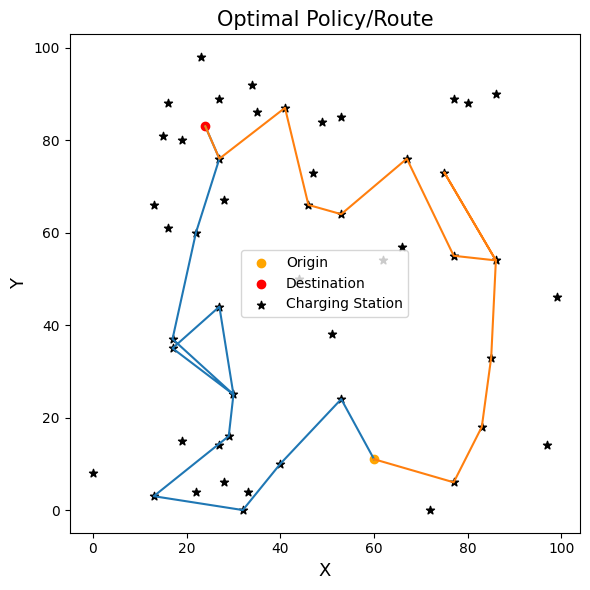

In [256]:
# Plot the route
fig, ax1 = plt.subplots(figsize=(6, 6))

# Plot the route/policy
for policy in list_policies:
    x_policy = []
    y_policy = []
    for index in policy:
        x, y = np.unravel_index(index, shape = m.map_shape)
        x_policy.append(x)
        y_policy.append(y)
    ax1.plot(x_policy, y_policy)

# Plot the origin
o_x, o_y = np.unravel_index(o, m.map_shape)
ax1.scatter(o_x, o_y, color = 'orange', label = 'Origin')

# Plot the destination
d_x, d_y = np.unravel_index(d, m.map_shape)
ax1.scatter(d_x, d_y, color = 'red', label = 'Destination')

# Plot the charging stations
c_x, c_y = np.unravel_index(m.charging_stations, m.map_shape)
ax1.scatter(c_x, c_y, color = 'black', label = 'Charging Station', marker = '*')

ax1.set_title('Optimal Policy/Route', fontsize = 15)
ax1.set_xlabel('X', fontsize = 13)
ax1.set_ylabel('Y', fontsize = 13)
ax1.legend()
fig.tight_layout()
fig.show()